In [2]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

from keras.applications import ResNet152
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras import backend as K
from keras.models import load_model

from sklearn.svm import SVR
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from xgboost import XGBRegressor

import progressbar
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

## Generate Labels

In [2]:
f_train = open("lamem/splits/train_1.txt").readlines()
f_test = open("lamem/splits/test_1.txt").readlines()
f_val = open("lamem/splits/val_1.txt").readlines()

X_train_list = [x[:12] for x in f_train]
Y_train = np.array([float(x[13:21]) for x in f_train])

X_test_list = [x[:12] for x in f_test]
Y_test = np.array([float(x[13:21]) for x in f_test])

X_val_list = [x[:12] for x in f_val]
Y_val = np.array([float(x[13:21]) for x in f_val])

In [46]:
with h5py.File("Y.h5", "w") as h5f:
    for i in range(len(Y_train)):
        h5f.create_dataset(X_train_list[i], data=Y_train[i])
    for i in range(len(Y_test)):
        h5f.create_dataset(X_test_list[i], data=Y_test[i])
    for i in range(len(Y_val)):
        h5f.create_dataset(X_val_list[i], data=Y_val[i])

In [32]:
h5f = h5py.File("test_features.h5")

X_test_valide = [x in set(h5f.keys()) for x in X_test_list]
X_train_list = [x for x, y in zip(X_test_list, X_test_valide) if y]
Y_train = [x for x, y in zip(Y_test, X_test_valide) if y]

/Users/jojo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


## Load dataset

In [3]:
X = np.load("lamem/X.npy")
Y = np.load("lamem/Y.npy")

In [4]:
print(X.shape, Y.shape)

(58741, 2048) (58741,)


In [14]:
train_set, test_set = train_test_split(range(len(X)), test_size=0.1)

## Prediction

### SVM

In [32]:
def my_custom_loss_func(y_true, y_pred):
    c, p = spearmanr(y_true, y_pred)
    return c
score = make_scorer(my_custom_loss_func, greater_is_better=True)

In [33]:
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV

ALGORITHMS = {
        'model': SVR(gamma='scale'),
        'params': {
            "kernel": ['rbf', 'sigmoid'], # 'poly', 'sigmoid'
            "C": [0.1, 1.0, 10.0],
            "epsilon": [0.001, 1.0],
        }
    }

CV = 3
model = GridSearchCV(
        ALGORITHMS['model'],
        ALGORITHMS['params'],
        cv=CV,
        scoring=score,
        n_jobs=-1,
        )

In [37]:
model = LinearSVR(C=1.0, epsilon=0.1)

In [38]:
model.fit(X[train_set], Y[train_set])

/Users/jojo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.1, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

In [39]:
pred = model.predict(X[test_set])
c, p = spearmanr(Y[test_set], pred)

print("Spearmanr Result: correlation: {:.5f}, p-value: {}".format(c, p))

Spearmanr Result: correlation: 0.58618, p-value: 0.0


### Neural network

In [19]:
from keras.layers import *
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU
from keras.backend import expand_dims
from keras.losses import MeanSquaredLogarithmicError
import tensorflow as tf
from tensorflow.keras.losses import MSE

def correlation_loss(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return 2*MSE(x,y) - r_num / r_den

In [180]:
input_feature = Input(shape=(2048,), name='Input')
x = Dense(512, activation='relu')(input_feature)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [181]:
model = Model(input_feature, x)
model.compile(optimizer='adam', loss=correlation_loss)

In [182]:
model.fit(X[train_set], Y[train_set], batch_size=256, epochs=10, validation_data=(X[test_set], Y[test_set]))

Epoch 1/10
186/186 [==============================] - 2s 9ms/step - loss: -0.4153 - val_loss: -0.6119
Epoch 2/10
186/186 [==============================] - 2s 8ms/step - loss: -0.5868 - val_loss: -0.6335
Epoch 3/10
186/186 [==============================] - 2s 10ms/step - loss: -0.6162 - val_loss: -0.6373
Epoch 4/10
186/186 [==============================] - 2s 9ms/step - loss: -0.6346 - val_loss: -0.6415
Epoch 5/10
186/186 [==============================] - 2s 9ms/step - loss: -0.6473 - val_loss: -0.6485
Epoch 6/10
186/186 [==============================] - 2s 9ms/step - loss: -0.6549 - val_loss: -0.6472
Epoch 7/10
186/186 [==============================] - 2s 9ms/step - loss: -0.6641 - val_loss: -0.6484
Epoch 8/10
186/186 [==============================] - 2s 9ms/step - loss: -0.6694 - val_loss: -0.6498
Epoch 9/10
186/186 [==============================] - 2s 9ms/step - loss: -0.6806 - val_loss: -0.6524
Epoch 10/10
186/186 [==============================] - 2s 9ms/step - loss: -0.684

In [183]:
pred = model.predict(X[test_set])
c, p = spearmanr(Y[test_set], pred)

print("Spearmanr Result: correlation: {:.5f}, p-value: {}".format(c, p))

Spearmanr Result: correlation: 0.67365, p-value: 0.0


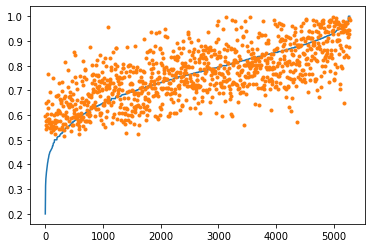

In [184]:
import matplotlib.pyplot as plt

c = list(range(0, len(Y[test_set]), 5))
index = np.argsort(Y[test_set])[c]
Y_pred = model.predict(X[test_set])

plt.plot(c, Y[test_set][index])
plt.plot(c, Y_pred[index], '.')

## Nomalized label

In [20]:
# Y_new = (Y-np.mean(Y))/np.std(Y)
Y_new = np.clip((Y-np.mean(Y))/np.std(Y), -1.0, 1.0)
# Y_new = (Y-np.min(Y))/(np.max(Y)-np.min(Y))

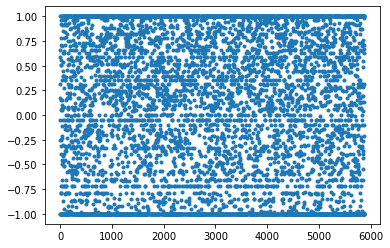

In [16]:
plt.plot(Y_new[test_set], ".")

In [21]:
def correlation_loss(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return 2*MSE(x,y) - r_num / r_den

In [34]:
activation = "tanh"

input_feature = Input(shape=(2048,), name='Input')
x = Dense(512, activation="relu")(input_feature)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(32, activation="relu")(x)
x = Dense(1, activation=activation)(x)

In [35]:
model = Model(input_feature, x)
model.compile(optimizer='adam', loss="mse")

In [39]:
model.fit(X[train_set], Y_new[train_set], batch_size=128, epochs=10, validation_data=(X[test_set], Y_new[test_set]))

Train on 52866 samples, validate on 5875 samples
Epoch 1/10
52866/52866 [==============================] - 4s 84us/sample - loss: 0.2788 - val_loss: 0.3097
Epoch 2/10
52866/52866 [==============================] - 4s 74us/sample - loss: 0.2743 - val_loss: 0.3053
Epoch 3/10
52866/52866 [==============================] - 4s 77us/sample - loss: 0.2740 - val_loss: 0.3063
Epoch 4/10
52866/52866 [==============================] - 4s 81us/sample - loss: 0.2676 - val_loss: 0.3095
Epoch 5/10
52866/52866 [==============================] - 4s 81us/sample - loss: 0.2641 - val_loss: 0.3222
Epoch 6/10
52866/52866 [==============================] - 4s 78us/sample - loss: 0.2597 - val_loss: 0.3208
Epoch 7/10
52866/52866 [==============================] - 4s 80us/sample - loss: 0.2597 - val_loss: 0.3091
Epoch 8/10
52866/52866 [==============================] - 4s 79us/sample - loss: 0.2523 - val_loss: 0.3146
Epoch 9/10
52866/52866 [==============================] - 4s 80us/sample - loss: 0.2480 - val_l

In [52]:
import keras
keras.__version__

'2.4.3'

In [43]:
model.save("model")

INFO:tensorflow:Assets written to: model/assets


In [40]:
pred = model.predict(X[test_set])
c, p = spearmanr(Y_new[test_set], pred)

print("Spearmanr Result: correlation: {:.5f}, p-value: {}".format(c, p))

Spearmanr Result: correlation: 0.66630, p-value: 0.0


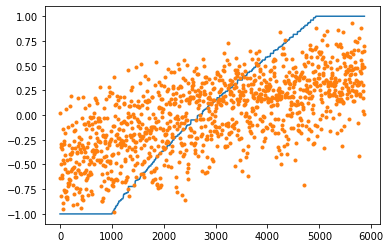

In [41]:
import matplotlib.pyplot as plt

c = list(range(0, len(Y_new[test_set]), 5))
index = np.argsort(Y_new[test_set])[c]
Y_new_pred = model.predict(X[test_set])
plt.plot(c, Y_new[test_set][index])
plt.plot(c, Y_new_pred[index], '.')

In [128]:
np.sum(Y_new[test_set]>1)

871

In [135]:
np.sum(Y_pred[Y[test_set]>0.5]>0.5) / np.sum(Y[test_set]>0.5)

0.9960560047327943

In [276]:
IMG_SIZE=(224, 224)
image = load_img("frame/dyson1.mp4-frame-200.jpg", target_size=IMG_SIZE)
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
features = ResNet152(weights="imagenet", include_top=False, pooling='avg').predict(image)

In [286]:
model.output

<tf.Tensor 'dense_112/Identity:0' shape=(None, 1) dtype=float32>

In [288]:
input_layer = model.get_layer("Input")
score_output = model.output

In [293]:
grads = K.gradients(score_output, input_layer.input)[0]

In [294]:
grads

<tf.Tensor 'gradients_5/dense_108/MatMul_grad/MatMul:0' shape=(None, 2048) dtype=float32>

## Visualization

In [47]:
class Model_Final:
    def __init__(self, IMG_SIZE=(224, 224)):
        self.model_res = ResNet152(weights="imagenet", include_top=False, pooling='avg')
        self.IMG_SIZE = IMG_SIZE
        input_layer = self.model_res.layers[0]
        self.model = load_model("model")
        self.model_final = Model(self.model_res.input, self.model(self.model_res.output))
        
        image_output = self.model_final.output[:]
        last_conv_layer = self.model_final.get_layer('conv5_block3_out')
        grads = K.gradients(image_output, last_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        self.iterate = K.function([self.model_final.input], [pooled_grads, last_conv_layer.output[0]])
        
    def load_image(self, image_path):
        image_original = load_img(image_path)
        image = cv2.resize(image_original, self.IMG_SIZE)
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
        return image, image_original
    
    def get_heatmap(self, image, save=False):
        pooled_grads_value, conv_layer_output_value = self.iterate([image])
        for i in range(512):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
        heatmap = np.mean(conv_layer_output_value, axis=-1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        if save:
            if not os.path.exists('figures/activation_maps/'):
                os.makedirs('figures/activation_maps/')
            plt.imsave('figures/activation_maps/{}_heatmap.png'.format(image_name), heatmap)
        return heatmap
    
    def get_transformed_image(self, image_path, save=False):
        image, image_original = self.load_image(image_path)
        heatmap = self.get_heatmap(image, save=save)
        heatmap = cv2.resize(heatmap, (image_original.shape[1], image_original.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = heatmap * 0.4 + image_original
        if save:
            cv2.imwrite('figures/activation_maps/{}_CAM.jpg'.format(image_name), superimposed_img)
        return superimposed_img

In [48]:
m = Model_Final()

In [ ]:
m.load_image("lamem/images/" + X_test_list[0])